# Exercise 15

# Fraud Detection

## Introduction

- Fraud Detection Dataset from Microsoft Azure: [data](http://gallery.cortanaintelligence.com/Experiment/8e9fe4e03b8b4c65b9ca947c72b8e463)

Fraud detection is one of the earliest industrial applications of data mining and machine learning. Fraud detection is typically handled as a binary classification problem, but the class population is unbalanced because instances of fraud are usually very rare compared to the overall volume of transactions. Moreover, when fraudulent transactions are discovered, the business typically takes measures to block the accounts from transacting to prevent further losses. 

In [12]:
%matplotlib inline
import random
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd

url = 'https://raw.githubusercontent.com/albahnsen/PracticalMachineLearningClass/master/datasets/15_fraud_detection.csv.zip'
df = pd.read_csv(url, index_col=0)

In [3]:
df.head()

,accountAge,digitalItemCount,sumPurchaseCount1Day,sumPurchaseAmount1Day,sumPurchaseAmount30Day,paymentBillingPostalCode - LogOddsForClass_0,accountPostalCode - LogOddsForClass_0,paymentBillingState - LogOddsForClass_0,accountState - LogOddsForClass_0,paymentInstrumentAgeInAccount,ipState - LogOddsForClass_0,transactionAmount,transactionAmountUSD,ipPostalCode - LogOddsForClass_0,localHour - LogOddsForClass_0,Label
0,2000,0,0,0.00,720.25,5.064533,0.421214,1.312186,0.566395,3279.574306,1.218157,599.00,626.164650,1.259543,4.745402,0
1,62,1,1,1185.44,2530.37,0.538996,0.481838,4.401370,4.500157,61.970139,4.035601,1185.44,1185.440000,3.981118,4.921349,0
2,2000,0,0,0.00,0.00,5.064533,5.096396,3.056357,3.155226,0.000000,3.314186,32.09,32.090000,5.008490,4.742303,0
3,1,1,0,0.00,0.00,5.064533,5.096396,3.331154,3.331239,0.000000,3.529398,133.28,132.729554,1.324925,4.745402,0
4,1,1,0,0.00,132.73,5.412885,0.342945,5.563677,4.086965,0.001389,3.529398,543.66,543.660000,2.693451,4.876771,0


In [4]:
df.shape, df.Label.sum(), df.Label.mean()

((138721, 16), 797, 0.0057453449730033666)

# Exercise 15.1

Partir train test desde el principio semilla aleatoria 42
Estimate a Logistic Regression and a Decision Tree y random forest

Evaluate using the following metrics:
* Accuracy
* F1-Score
* F_Beta-Score (Beta=10)

Comment about the results

In [5]:
#Creamos las variable x y y inicialmente para preparar la división del dataset
X=df.drop(['Label'],axis=1)
y=df.Label


In [6]:
#Dividimos el dataset en train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


In [11]:
#Modelos
models = {'lr': LogisticRegression(solver='lbfgs'),
          'dt': DecisionTreeClassifier(),
          'rf': RandomForestClassifier()}

In [14]:
for model in models.keys():
    models[model].fit(X_train, y_train)

In [17]:
#Calculo de y_pred
y_pred = pd.DataFrame(index=X_test.index, columns=models.keys())
for model in models.keys():
    y_pred[model] = models[model].predict(X_test)
print(y_pred.head())

        lr  dt  rf
136269   0   0   0
45671    0   0   0
103047   0   0   0
31511    0   0   0
86154    0   1   0


In [18]:
d = {'Model': ['Logistic Regression ', 'Decision Tree', 'Random Forest'],
     'Accuracy': [metrics.accuracy_score(y_pred['lr'], y_test),metrics.accuracy_score(y_pred['dt'], y_test),metrics.accuracy_score(y_pred['rf'], y_test)],
    'f1 acore' : [metrics.f1_score(y_pred['lr'], y_test),metrics.f1_score(y_pred['dt'], y_test),metrics.f1_score(y_pred['rf'], y_test)],
    'F_Beta-Score,Beta=10' : [metrics.fbeta_score(y_pred['lr'], y_test,beta=10),metrics.fbeta_score(y_pred['dt'], y_test,beta=10),metrics.fbeta_score(y_pred['rf'], y_test,beta=10)]
    }
acc= pd.DataFrame(data=d)
acc

,Model,Accuracy,f1 acore,"F_Beta-Score,Beta=10"
0,Logistic Regression,0.994291,0.000000,0.000000
1,Decision Tree,0.988466,0.126638,0.111802
2,Random Forest,0.994147,0.097778,0.383368


In [32]:
# Instanciate a PCA object for the sake of easy visualisation
pca = PCA(n_components = 2)

# Fit and transform x to visualise inside a 2D feature space
x_vis = pca.fit_transform(X_train)
x_vis_test=pca.fit_transform(X_test)

# Exercise 15.2

Under-sample the negative class using random-under-sampling

Which is parameter for target_percentage did you choose?
How the results change?

**Only apply under-sampling to the training set, evaluate using the whole test set**

Primero, es necesario definir las funciones para hacer under-sampling

In [19]:
def plot_two_classes(X, y, subplot=False, size=(10, 10)):
    # Plot the two classes
    if subplot == False:
        fig, subplot = plt.subplots(nrows=1, ncols=1, figsize=size)
        
    subplot.scatter(X[y==0, 0], X[y==0, 1], label="Class #0", 
                    alpha=0.5, s=70)
    subplot.scatter(X[y==1, 0], X[y==1, 1], label="Class #1", 
                    alpha=0.5, s=70)
    subplot.legend()
    return subplot

def UnderSampling(X, y, target_percentage=0.5, seed=None):
    # Assuming minority class is the positive
    n_samples = y.shape[0]
    n_samples_0 = (y == 0).sum()
    n_samples_1 = (y == 1).sum()

    n_samples_0_new =  n_samples_1 / target_percentage - n_samples_1
    n_samples_0_new_per = n_samples_0_new / n_samples_0

    filter_ = y == 0

    np.random.seed(seed)
    rand_1 = np.random.binomial(n=1, p=n_samples_0_new_per, size=n_samples)
    
    filter_ = filter_ & rand_1
    filter_ = filter_ | (y == 1)
    filter_ = filter_.astype(bool)
    
    return X[filter_], y[filter_]

In [31]:
#Relizamos under-sampling al data ser de train y comparamos el resultado
X_u_train, y_u_train = UnderSampling(X_train, y_train, 0.1, 42)

us = {'Data set': ['Label = 0','Label = 1','Complete'],
      'Original': [X_train[y_train==0].shape[0],X_train[y_train==1].shape[0],y_train.shape[0]],
      'Under sampling' : [X_u_train[y_u_train==0].shape[0],X_u_train[y_u_train==1].shape[0],X_u_train.shape[0]] 
}

Under = pd.DataFrame(data=us)
Under

,Data set,Original,Under sampling
0,Label = 0,103441,5247
1,Label = 1,599,599
2,Complete,104040,5846


## undersampling al training set

Target percentage 0.1
Tamaño de X: 5985


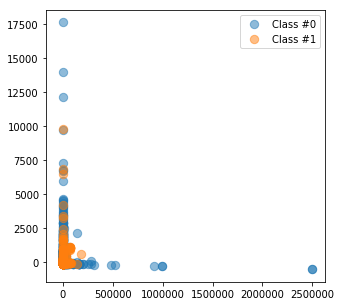

                  Model  Accuracy  f1 acore  F_Beta-Score
0  Logistic Regression   0.993945  0.000000      0.000000
1         Decision Tree  0.973155  0.021030      0.013378
2         Random Forest  0.990802  0.047761      0.058138
Target percentage 0.2
Tamaño de X: 2984


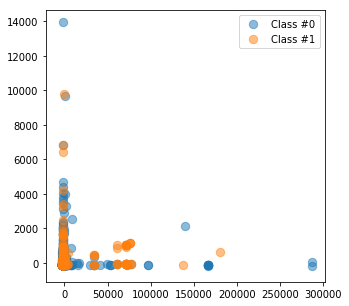

                  Model  Accuracy  f1 acore  F_Beta-Score
0  Logistic Regression   0.988524  0.009950      0.009807
1         Decision Tree  0.748969  0.010457      0.005401
2         Random Forest  0.977394  0.029703      0.019805
Target percentage 0.3
Tamaño de X: 1955


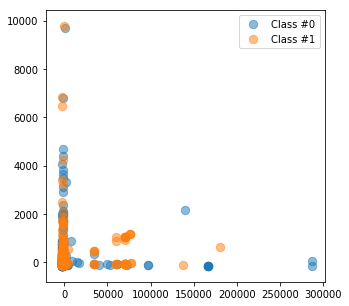

                  Model  Accuracy  f1 acore  F_Beta-Score
0  Logistic Regression   0.986592  0.033264      0.028353
1         Decision Tree  0.652922  0.012308      0.006317
2         Random Forest  0.953663  0.024287      0.013922
Target percentage 0.4
Tamaño de X: 1457


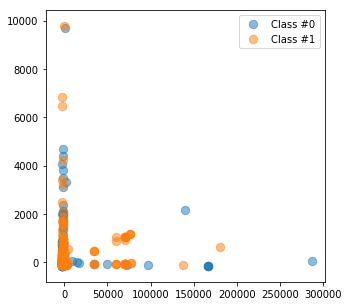

                  Model  Accuracy  f1 acore  F_Beta-Score
0  Logistic Regression   0.975750  0.029988      0.019568
1         Decision Tree  0.785531  0.010114      0.005245
2         Random Forest  0.924887  0.016610      0.009058
Target percentage 0.5
Tamaño de X: 1173


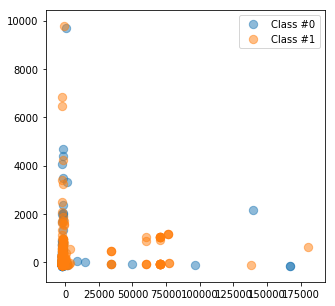

                  Model  Accuracy  f1 acore  F_Beta-Score
0  Logistic Regression   0.829676  0.015336      0.008006
1         Decision Tree  0.765289  0.015481      0.008008
2         Random Forest  0.811597  0.018034      0.009384


In [41]:
for target_percentage in [0.1, 0.2, 0.3, 0.4, 0.5]:
    X_u_train, y_u_train = UnderSampling(x_vis, y_train, target_percentage, 1)
    for model in models.keys():
        models[model].fit(X_u_train, y_u_train)
    y_pred_2 = pd.DataFrame(index=X_test.index, columns=models.keys())
    for model in models.keys():
        y_pred_2[model] = models[model].predict(x_vis_test)
    print('\033[1;37mTarget percentage', target_percentage)
    print('\033[1;37mTamaño de X:' ,X_u_train.shape[0])
    plot_two_classes(X_u_train, y_u_train, size=(5, 5))
    plt.show() 
    
    d2 = {'Model': ['Logistic Regression ', 'Decision Tree', 'Random Forest'],
     'Accuracy': [metrics.accuracy_score(y_pred_2['lr'], y_test),metrics.accuracy_score(y_pred_2['dt'], y_test),metrics.accuracy_score(y_pred_2['rf'], y_test)],
    'f1 acore' : [metrics.f1_score(y_pred_2['lr'], y_test),metrics.f1_score(y_pred_2['dt'], y_test),metrics.f1_score(y_pred_2['rf'], y_test)],
    'F_Beta-Score' : [metrics.fbeta_score(y_pred_2['lr'], y_test,beta=10),metrics.fbeta_score(y_pred_2['dt'], y_test,beta=10),metrics.fbeta_score(y_pred_2['rf'], y_test,beta=10)]
    }
    acc2= pd.DataFrame(data=d2)
    print (acc2)
   

# Exercise 15.3

Same analysis using random-over-sampling

Definición función oversampling

In [42]:
import random
def OverSampling(X, y, target_percentage=0.5, seed=None):
    # Assuming minority class is the positive
    n_samples = y.shape[0]
    n_samples_0 = (y == 0).sum()
    n_samples_1 = (y == 1).sum()

    n_samples_1_new =  -target_percentage * n_samples_0 / (target_percentage- 1)
    n_samples_1_new =int(n_samples_1_new)

    np.random.seed(seed)
    filter_ = np.random.choice(X[y == 1].shape[0], int(n_samples_1_new))
    # filter_ is within the positives, change to be of all
    filter_ = np.nonzero(y == 1)[0][filter_]
    
    filter_ = np.concatenate((filter_, np.nonzero(y == 0)[0]), axis=0)
    return X[filter_], y[filter_]

## oversampling al training set

Target percentage 0.1
Tamaño de X: 114934


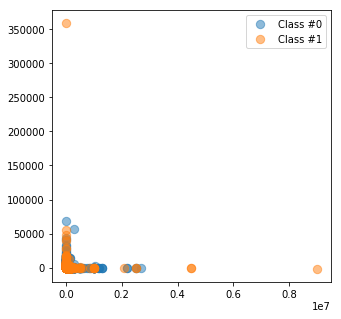

                  Model  Accuracy  f1 acore  F_Beta-Score
0  Logistic Regression   0.994291  0.000000      0.000000
1         Decision Tree  0.778322  0.015117      0.007831
2         Random Forest  0.505089  0.009807      0.005009
Target percentage 0.2
Tamaño de X: 129301


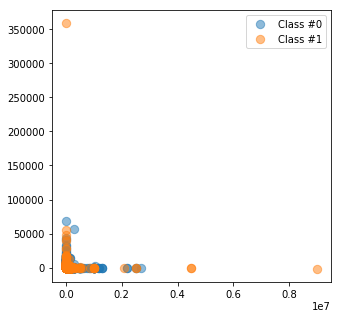

                  Model  Accuracy  f1 acore  F_Beta-Score
0  Logistic Regression   0.213633  0.009731      0.004950
1         Decision Tree  0.739569  0.012896      0.006655
2         Random Forest  0.884086  0.014706      0.007801
Target percentage 0.3
Tamaño de X: 147772


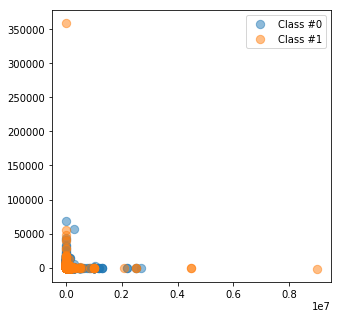

                  Model  Accuracy  f1 acore  F_Beta-Score
0  Logistic Regression   0.994291  0.000000      0.000000
1         Decision Tree  0.897725  0.014996      0.008009
2         Random Forest  0.489634  0.008959      0.004574
Target percentage 0.4
Tamaño de X: 172401


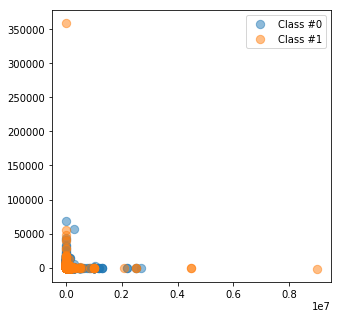

                  Model  Accuracy  f1 acore  F_Beta-Score
0  Logistic Regression   0.994291  0.000000      0.000000
1         Decision Tree  0.779043  0.014152      0.007331
2         Random Forest  0.772729  0.013270      0.006870
Target percentage 0.5
Tamaño de X: 206882


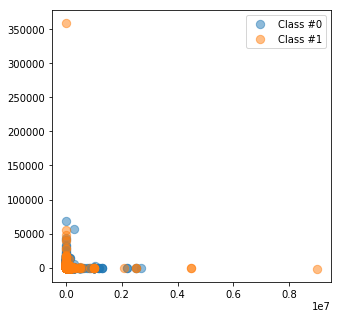

                  Model  Accuracy  f1 acore  F_Beta-Score
0  Logistic Regression   0.994291  0.000000      0.000000
1         Decision Tree  0.747787  0.012643      0.006529
2         Random Forest  0.803178  0.013299      0.006912


In [47]:
for target_percentage in [0.1, 0.2, 0.3, 0.4, 0.5]:
    X_o_train, y_o_train = OverSampling(x_vis, y_train, target_percentage, 42)
    y_o_train.isnull()
    y_o_train.fillna(1, inplace=True)
    for model in models.keys():
        models[model].fit(X_o_train, y_o_train)
    y_pred_3 = pd.DataFrame(index=X_test.index, columns=models.keys())
    for model in models.keys():
        y_pred_3[model] = models[model].predict(x_vis_test)
    print('\33[1;37mTarget percentage', target_percentage)
    print('\33[1;37mTamaño de X:' ,X_o_train.shape[0])
    plot_two_classes(X_o_train, y_o_train, size=(5, 5))
    plt.show()
    d3 = {'Model': ['Logistic Regression ', 'Decision Tree', 'Random Forest'],
     'Accuracy': [metrics.accuracy_score(y_pred_3['lr'], y_test),metrics.accuracy_score(y_pred_3['dt'], y_test),metrics.accuracy_score(y_pred_3['rf'], y_test)],
    'f1 acore' : [metrics.f1_score(y_pred_3['lr'], y_test),metrics.f1_score(y_pred_3['dt'], y_test),metrics.f1_score(y_pred_3['rf'], y_test)],
    'F_Beta-Score' : [metrics.fbeta_score(y_pred_3['lr'], y_test,beta=10),metrics.fbeta_score(y_pred_3['dt'], y_test,beta=10),metrics.fbeta_score(y_pred_3['rf'], y_test,beta=10)]
    }
    acc3= pd.DataFrame(data=d3)
    print (acc3)

# Exercise 15.4 (3 points)

Evaluate the results using SMOTE

Which parameters did you choose?

In [48]:
def SMOTE(X, y, target_percentage=0.5, k=5, seed=None):
    
    # New samples
    n_samples = y.shape[0]
    n_samples_0 = (y == 0).sum()
    n_samples_1 = (y == 1).sum()    
    n_samples_1_new =  int(-target_percentage * n_samples_0 / (target_percentage- 1) - n_samples_1)
    
    # A matrix to store the synthetic samples
    new = np.zeros((n_samples_1_new, x_vis.shape[1]))
    
    # Create seeds
    np.random.seed(seed)
    seeds = np.random.randint(1, 1000000, 3)
    
    # Select examples to use as base
    np.random.seed(seeds[0])
    sel_ = np.random.choice(y[y==1].shape[0], n_samples_1_new)
    
    # Define random seeds (2 per example)
    np.random.seed(seeds[1])
    nn__ = np.random.choice(k, n_samples_1_new)
    np.random.seed(seeds[2])
    steps = np.random.uniform(size=n_samples_1_new)  

    # For each selected examples create one synthetic case
    for i, sel in enumerate(sel_):
        # Select neighbor
        nn_ = nn__[i]
        step = steps[i]
        # Create new sample
        new[i, :] = X[y==1][sel] - step * (X[y==1][sel] - X[y==1][nn_])
    
    X = np.vstack((X, new))
    y = np.append(y, np.ones(n_samples_1_new))
    
    return X, y

Target percentage 0.25 k  5
y.shape =  137921 y.mean() =  0.24999818736813104


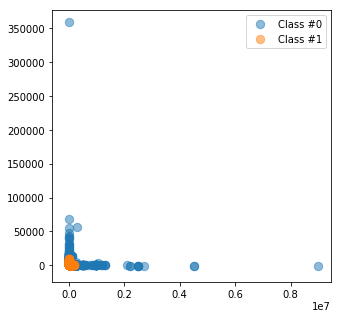

Tamaño de X: 137921
Target percentage 0.25 k  15
y.shape =  137921 y.mean() =  0.24999818736813104


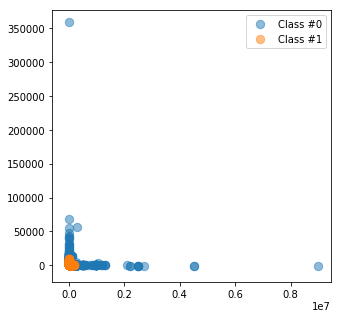

Tamaño de X: 137921
                  Model  Accuracy  f1 acore  F_Beta-Score
0  Logistic Regression   0.993455  0.000000      0.000000
1         Decision Tree  0.958104  0.024177      0.014061
2         Random Forest  0.963525  0.023166      0.013786
Target percentage 0.5 k  5
y.shape =  206882 y.mean() =  0.5


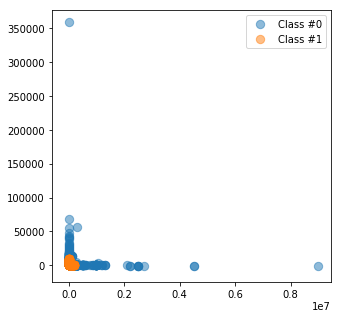

Tamaño de X: 206882
Target percentage 0.5 k  15
y.shape =  206882 y.mean() =  0.5


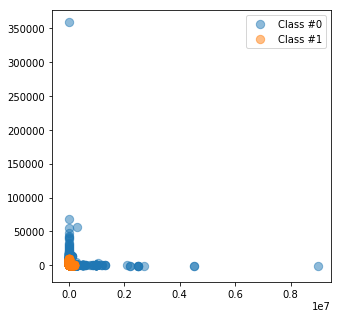

Tamaño de X: 206882
                  Model  Accuracy  f1 acore  F_Beta-Score
0  Logistic Regression   0.786108  0.019561      0.010141
1         Decision Tree  0.938006  0.016468      0.009136
2         Random Forest  0.943341  0.022874      0.012799


In [50]:
for target_percentage in [0.25, 0.5]:
    for k in [5, 15]:
        X_s_train, y_s_train = SMOTE(x_vis, y_train, target_percentage, k, seed=42)
        for model in models.keys():
            models[model].fit(X_s_train, y_s_train)
        y_pred_4 = pd.DataFrame(index=X_test, columns=models.keys())
        for model in models.keys():
            y_pred_4[model] = models[model].predict(x_vis_test)
        print('\33[1;37mTarget percentage', target_percentage, 'k ', k)
        print('\33[1;37my.shape = ',y_s_train.shape[0], 'y.mean() = ', y_s_train.mean())
        plot_two_classes(X_s_train, y_s_train, size=(5, 5))
        plt.show()
        print('\33[1;37mTamaño de X:' ,X_s_train.shape[0])
        d4 = {'Model': ['Logistic Regression ', 'Decision Tree', 'Random Forest'],
         'Accuracy': [metrics.accuracy_score(y_pred_4['lr'], y_test),metrics.accuracy_score(y_pred_4['dt'], y_test),metrics.accuracy_score(y_pred_4['rf'], y_test)],
        'f1 acore' : [metrics.f1_score(y_pred_4['lr'], y_test),metrics.f1_score(y_pred_4['dt'], y_test),metrics.f1_score(y_pred_4['rf'], y_test)],
        'F_Beta-Score' : [metrics.fbeta_score(y_pred_4['lr'], y_test,beta=10),metrics.fbeta_score(y_pred_4['dt'], y_test,beta=10),metrics.fbeta_score(y_pred_4['rf'], y_test,beta=10)]
        }
        acc4= pd.DataFrame(data=d4)
        print (acc4)

# Exercise 15.5 (3 points)

Evaluate the results using Adaptive Synthetic Sampling Approach for Imbalanced
Learning (ADASYN)

http://www.ele.uri.edu/faculty/he/PDFfiles/adasyn.pdf
https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.ADASYN.html#rf9172e970ca5-1

In [51]:
!pip install imblearn

In [52]:
from collections import Counter
from imblearn.over_sampling import ADASYN
ada = ADASYN(random_state=42)
X_ada, y_ada = ada.fit_resample(x_vis, y_train)
print(x_vis[y_train==0].shape[0])
print(X_ada.shape[0])

103441
207045


Tamaño de X: 207045


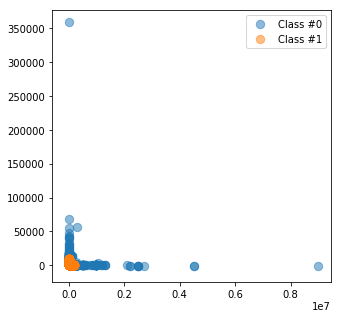

                  Model  Accuracy  f1 acore  F_Beta-Score
0  Logistic Regression   0.785243  0.017673      0.009162
1         Decision Tree  0.967994  0.019435      0.011870
2         Random Forest  0.962602  0.019652      0.011651


In [56]:
for model in models.keys():
    models[model].fit(X_ada, y_ada)
y_pred_5 = pd.DataFrame(index=X_test.index, columns=models.keys())
for model in models.keys():
    y_pred_5[model] = models[model].predict(x_vis_test)
print('\33[1;37mTamaño de X:' ,X_ada.shape[0])
plot_two_classes(X_ada, y_ada, size=(5, 5))
plt.show()
d5 = {'Model': ['Logistic Regression ', 'Decision Tree', 'Random Forest'],
'Accuracy': [metrics.accuracy_score(y_pred_5['lr'], y_test),metrics.accuracy_score(y_pred_5['dt'], y_test),metrics.accuracy_score(y_pred_5['rf'], y_test)],
'f1 acore' : [metrics.f1_score(y_pred_5['lr'], y_test),metrics.f1_score(y_pred_5['dt'], y_test),metrics.f1_score(y_pred_5['rf'], y_test)],
'F_Beta-Score' : [metrics.fbeta_score(y_pred_5['lr'], y_test,beta=10),metrics.fbeta_score(y_pred_5['dt'], y_test,beta=10),metrics.fbeta_score(y_pred_5['rf'], y_test,beta=10)]}
acc5= pd.DataFrame(data=d5)
print (acc5)

# Exercise 15.6 (3 points)

Compare and comment about the results

Los resultados de este ejercicio nos muestran distintos desempeños desde la precisión de los modelos y el uso de los recursos computacionales. 

En términos de recursos computacionales, las pruebas iniciales con los modelos sin modificar el data set, tienen un buen desempeño en su ejecución en la medida en que el tiempo es muy corto. Mientras que el enfoque que tarda más en ejecutarse es el SMOTE, seguido del over sampling. Lo cual tiene sentido si se entiende que para estos casos se crean observaciones adicionales y en los primeros se reduce.

Por otro lado, si realizamos un análisis a la luz de las métricas de accuracy, f1-score y f-beta, el desempeño de los distintos modelos varía. De forma general, se evidencia que Random Forest tiende a obtener los mayores puntajes en las distintas pruebas, mientras que Logistic Regression obtiene los menores valores de accuracy. Sin embargo, tal como plantean Leevy et al. [2018], el accuracy no logra capturar el desempeño general del modelo, por lo tanto es conveniente evaluar el f1-score y f-beta en donde se contemplan tanto los verdaderos positivos y negativos como el recall. De esta forma, el modelo que presenta el peor desempeño a nivel general es Logistic Regression que en la prueba SMOTE y over sampling obtiene valor de 0 en las dos métricas. Pero en el enfoque Under sampling obtiene los mejores puntajes en comparación con los otros modelos.

Con resultado general, se tiene el planteamiento de la librería iblearn en donde el desempeño computacional y de las métricas es aceptable, en la medida en que su ejecución es ágil y las métricas nos muestran la misma tendencia que los modelos anteriores. Para este caso, el Random Forest vuelve a tener el mejor desempeño no solo en accuracy, sino también en f1-score y f-beta. Mientras que Logistic regression tiene el peor desempeño en todas las métricas. Por lo tanto, podemos concluir que este último enfoque para resolver un problema de clases desbalanceadas, nos muestra mejor el comportamiento con un buen desempeño computacional. Por lo tanto, en términos prácticos, podemos tomar este para evaluar los modelos que queramos emplear a luz de las métricas planteadas.